# This is a userguide test notebook

## Data access
 

![image 1](https://api.nga.gov/iiif/99758d9d-c10b-4d02-a198-7e49afb1f3a6/full/!800,800/0/default.jpg)

**Above is an image by Monet**

In [1]:
import os
import pandas as pd
from arcgis.gis import GIS
import requests
import geopandas as gpd
import folium

Use the GRID3 data portal to find data you would like to use: `https://data.grid3.org/`

Or see a list of GRID3 REST services available: `https://services3.arcgis.com/BU6Aadhn6tbBEdyk/arcgis/rest/services`

In [2]:

url = "https://services3.arcgis.com/BU6Aadhn6tbBEdyk/arcgis/rest/services/GRID3_NGA_roads/FeatureServer/0/query"
 
params = {
        "where": "1=1",
        "outFields": "*",
        "outSR": 4326,
        "f": "json" 
    }

resp = requests.get(url, params=params)
data = resp.json()
data.keys()

dict_keys(['objectIdFieldName', 'uniqueIdField', 'globalIdFieldName', 'geometryProperties', 'geometryType', 'spatialReference', 'fields', 'exceededTransferLimit', 'features'])

In [3]:

features = data["features"] #use features as the key to get list of features from this dataset

# attributes
df = pd.json_normalize([f["attributes"] for f in features])

geoms = []

from shapely.geometry import LineString

for f in features:
    geom = f["geometry"]

    if "paths" in geom:
        # most road features have one path
        geoms.append(LineString(geom["paths"][0]))
    else:
        geoms.append(None)
        
        
gdf = gpd.GeoDataFrame(
    df,
    geometry=geoms,
    crs="EPSG:4326"
)

gdf.head()
 


OBJECTID                                id  country iso3       source_id  \
0         1  08059fffffffffff046f5212a07291c3  Nigeria  NGA  Overture / OSM   
1         2  08059fffffffffff046ff6a34145d397  Nigeria  NGA  Overture / OSM   
2         3  08059fffffffffff046ff6d48288b3ef  Nigeria  NGA  Overture / OSM   
3         4  08059fffffffffff046ff775b238a897  Nigeria  NGA  Overture / OSM   
4         5  08059fffffffffff046fff05b325608b  Nigeria  NGA  Overture / OSM   

          class  speed_estimate speed_estimate_method road_surface names  \
0  unclassified              40     literature review                      
1  unclassified              40     literature review                      
2  unclassified              40     literature review                      
3  unclassified              40     literature review                      
4      tertiary              50                   GPS                      

  subclass speed_limits  date    source_acronym  Shape__Length  \
0     None           \r  2025  OVERTURE_OSM_001    5509.471374   
1                        2025  OVERTURE_OSM_001    2944.939957   
2                        2025  OVERTURE_OSM_001    3355.942042   
3                        2025  OVERTURE_OSM_001    3808.948460   
4                        2025  OVERTURE_OSM_001    7136.589369   

                                            geometry  
0  LINESTRING (6.75328 9.90715, 6.75328 9.90717, ...  
1  LINESTRING (6.78229 9.88151, 6.78231 9.88163, ...  
2  LINESTRING (6.80792 9.88413, 6.80758 9.8839, 6...  
3  LINESTRING (6.81537 9.84995, 6.81475 9.84981, ...  
4  LINESTRING (6.75366 9.82817, 6.75391 9.82827, ...

<Axes: >

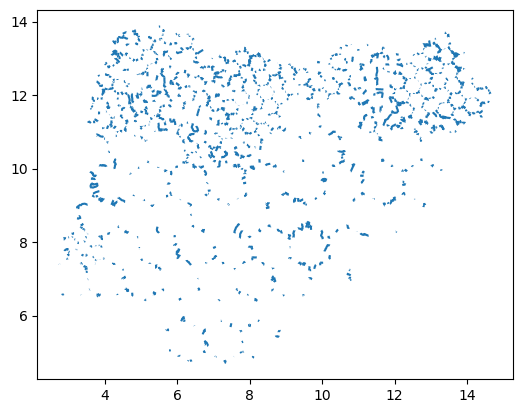

In [4]:
gdf.plot()

## Using Folium to visualize data

The package `folium` is a great way to visualize spatial data in Python. Below is an example of how to use it.


In [10]:


# center the map on your data
minx, miny, maxx, maxy = gdf.total_bounds

center = [
    (miny + maxy) / 2,
    (minx + maxx) / 2
]

m = folium.Map(
    location=center,
    zoom_start=8,
    tiles="CartoDB positron" #"OpenStreetMap"  # basemap
)

folium.GeoJson(
    gdf,
    name="GRID3 Roads",
    popup=folium.GeoJsonPopup(
        fields=list(df.columns)[:5]  # limit fields
    )
).add_to(m)



folium.LayerControl().add_to(m)

m